In [1]:
import numpy as np
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import glob
import re
import math


In [2]:
# from the description of the data set at
# kaggle.com/beyjin/movies-1990-to-2017/home#Movie_Writer.csv
# we know that we have multiple csv files with information on
# roughly 200000 movies let's find out what information this is
# and try to answer some questions with the data set 

In [3]:
# check what date we have
os.listdir('data')

['Movie_Actors.csv',
 'Movie_AdditionalRating.csv',
 'Movie_Genres.csv',
 'Movie_Movies.csv',
 'Movie_Writer.csv']

In [4]:
# from the kaggle website we know that Movie_Movies.csv
# is the most important file; let's read it into a data frame
# using default values
df = pd.read_csv('data/Movie_Movies.csv')
df.head(5)

C:\Users\genaucka\AppData\Local\Continuum\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Awards,Country,DVD,Director,Language,Plot,Poster,Production,Rated,Released,Runtime,Title,Type,Website,Year,imdbID,imdbRating,imdbVotes
0,NaN,USA,NaN,Rose Cummings,English,Rachel constantly hears her baby cry from the ...,NaN,NaN,NaN,26 Apr 2012,20 min,Baby's Breath,movie,NaN,2012,tt2268369,NaN,NaN
1,NaN,USA,NaN,James Byrne,NaN,The struggle against unfortunate circumstances...,NaN,NaN,NaN,NaN,9 min,Winter Trees,movie,NaN,2008,tt1560760,NaN,NaN
2,NaN,USA,NaN,Dimitri Buchowetzki,NaN,NaN,NaN,NaN,NaN,27 Mar 1926,50 min,The Crown of Lies,movie,NaN,1926,tt0016750,NaN,NaN
3,NaN,USA,NaN,Julia Hechler,English,"A Gift introduces Samuel Green, Washington Sta...",NaN,NaN,NaN,27 May 2013,2 min,A Gift,movie,NaN,2013,tt3405286,NaN,NaN
4,NaN,Sri Lanka,NaN,Udara Siriruwan,Sinhalese,NaN,NaN,NaN,NaN,20 Mar 2014,23 min,Journey,movie,NaN,2014,tt3816698,NaN,NaN


In [5]:
# this has worked well; we come to the warning later
# how big is that data set?
# which variables do we have per movie?
s = df.shape
print ('The data has {:d} rows (i.e. movies) and {:d} columns (i.e. infos on each movie) \n\n'.format(s[0],s[1]))

print ('Per movie we have these infos:\n')
for v in list(df.columns):
    print(v)

The data has 178687 rows (i.e. movies) and 18 columns (i.e. infos on each movie) 


Per movie we have these infos:

Awards
Country
DVD
Director
Language
Plot
Poster
Production
Rated
Released
Runtime
Title
Type
Website
Year
imdbID
imdbRating
imdbVotes


In [6]:
# from the kaggle data set info site we have learned that
# 'NOT_GIVEN' is a missing; let's replace that and 'NaN'
# with np.nan
df.replace(['NOT_GIVEN','NaN'],[np.nan,np.nan],inplace=True)


In [7]:
# let's get a quick description of the data; as far as possible
# having not done any thorough data cleaning yet
# with NaN's removed
print(df.describe())

         imdbRating
count  62073.000000
mean       6.416236
std        1.360472
min        1.000000
25%        5.600000
50%        6.500000
75%        7.300000
max       10.000000


In [8]:
# there is only one numerical variable; the rest is probably string objects
df.dtypes

Awards         object
Country        object
DVD            object
Director       object
Language       object
Plot           object
Poster         object
Production     object
Rated          object
Released       object
Runtime        object
Title          object
Type           object
Website        object
Year           object
imdbID         object
imdbRating    float64
imdbVotes      object
dtype: object

In [9]:
# let's check the warning about column 14
# pandas said the objects there are of mixed data type
# which one is it?
print(df[df.columns[14]].head(20))

0     2012
1     2008
2     1926
3     2013
4     2014
5     2014
6     2009
7     1915
8     1966
9     2005
10    2014
11    2016
12    2017
13    2002
14    2015
15    2014
16    2004
17    2004
18    2011
19    2008
Name: Year, dtype: object


In [10]:
# Seems like integer-like.
# Year should be an easy variable to simply
# convert into a datetime object
# it works for the first 20 but when we try it for all
# then there is an error raised
print(pd.to_datetime(df[df.columns[14]].head(20),format='%Y'))

0    2012-01-01
1    2008-01-01
2    1926-01-01
3    2013-01-01
4    2014-01-01
5    2014-01-01
6    2009-01-01
7    1915-01-01
8    1966-01-01
9    2005-01-01
10   2014-01-01
11   2016-01-01
12   2017-01-01
13   2002-01-01
14   2015-01-01
15   2014-01-01
16   2004-01-01
17   2004-01-01
18   2011-01-01
19   2008-01-01
Name: Year, dtype: datetime64[ns]


In [11]:
# let's look at the error
pd.to_datetime(df[df.columns[14]],format='%Y')

TypeError: 'float' object is unsliceable

In [12]:
# we get a TypeError; to_datetime expects strings
# so pandas made some years into strings
# some of them into float
# let's make them all to integer and then to string
# to get the format we need;
# but check closely if it works
def int_str(x):
    return(str(int(x)))

def cast_analysis(x,cast_func):
    """function that tries to cast via
    cast_func all elements in x; collects
    uncastables and returns those
    and returns the vector x cast with np.nan
    where not castable"""
    problem_entries = []
    x_cast = []
    for v in enumerate(x):
        try:
            x_cast.append(cast_func(v[1]))
        except:
            x_cast.append(np.nan)
            problem_entries.append(v)
    
    return((problem_entries,x_cast))

# let's run the cast and check which ones do not work
problem_entries, x_cast = cast_analysis(df[df.columns[14]],cast_func=int_str)


In [13]:
# now let's check which ones we cannot cast
print(problem_entries[0:10])

[(123293, nan), (174976, '2003–2005'), (175429, '2007–2011'), (176137, '2010–2013'), (176358, '2012–2016')]


In [14]:
# we have year ranges given; maybe those are TV series
for p in problem_entries:
    print(df.iloc[p[0],:])
    print('\n')

Awards        NaN
Country       NaN
DVD           NaN
Director      NaN
Language      NaN
Plot          NaN
Poster        NaN
Production    NaN
Rated         NaN
Released      NaN
Runtime       NaN
Title         NaN
Type          NaN
Website       NaN
Year          NaN
imdbID        NaN
imdbRating    NaN
imdbVotes     NaN
Name: 123293, dtype: object


Awards                                                   1 win.
Country                                                      UK
DVD                                                         NaN
Director                                                    NaN
Language                                                English
Plot          Animated sketches take a darkly satirical swip...
Poster        https://images-na.ssl-images-amazon.com/images...
Production                                                  NaN
Rated                                                       NaN
Released                                            09 Feb 2003
Runtim

In [15]:
# indeed they are series
# but we also see that we have a release date, so we will
# have a variable "year_final_release" which is in the case
# of a movie the release year and in case of the series
# the year of the final season
# but firstly this value array is handy for the next step
problem_entries_v = [x[1] for x in problem_entries]
print(problem_entries_v)

[nan, '2003–2005', '2007–2011', '2010–2013', '2012–2016']


In [16]:
df[df.columns[14]].replace(problem_entries_v,
                          [np.nan, '2005', '2011', '2013', '2016'],
                           inplace = True)

In [17]:
# now we run the cast analysis again and only nan is left
problem_entries, x_cast = cast_analysis(df[df.columns[14]],cast_func=int_str)
print(problem_entries)

[(123293, nan)]


In [18]:
# we create the new variable, as announced
df['year_final_release'] = x_cast

In [19]:
# let's try if we can now cast all years to date_time objects
problem_entries, x_cast = cast_analysis(df['year_final_release'],cast_func=pd.to_datetime)
print(problem_entries)

[]


In [20]:
# yes, we have no more cast problems and we know what the variable means
df['year_final_release'] = x_cast
print(df['year_final_release'].head(20))
print(df['year_final_release'].tail(20))

0    2012-01-01
1    2008-01-01
2    1926-01-01
3    2013-01-01
4    2014-01-01
5    2014-01-01
6    2009-01-01
7    1915-01-01
8    1966-01-01
9    2005-01-01
10   2014-01-01
11   2016-01-01
12   2017-01-01
13   2002-01-01
14   2015-01-01
15   2014-01-01
16   2004-01-01
17   2004-01-01
18   2011-01-01
19   2008-01-01
Name: year_final_release, dtype: datetime64[ns]
178667   1999-01-01
178668   1999-01-01
178669   1999-01-01
178670   1999-01-01
178671   1999-01-01
178672   1999-01-01
178673   1999-01-01
178674   1999-01-01
178675   1999-01-01
178676   1999-01-01
178677   1999-01-01
178678   1999-01-01
178679   1999-01-01
178680   1999-01-01
178681   1999-01-01
178682   1999-01-01
178683   1999-01-01
178684   1999-01-01
178685   1999-01-01
178686   1999-01-01
Name: year_final_release, dtype: datetime64[ns]


In [21]:
# however, now we see in the tail a lot of "1999" dates
# is it ordered, or have many years been cast wrongly?
# let's check the original variable again
print(df[df.columns[14]].tail(40))


178647    1999
178648    1999
178649    1999
178650    1999
178651    1999
178652    1999
178653    1999
178654    1999
178655    1999
178656    1999
178657    1999
178658    1999
178659    1999
178660    1999
178661    1999
178662    1999
178663    1999
178664    1999
178665    1999
178666    1999
178667    1999
178668    1999
178669    1999
178670    1999
178671    1999
178672    1999
178673    1999
178674    1999
178675    1999
178676    1999
178677    1999
178678    1999
178679    1999
178680    1999
178681    1999
178682    1999
178683    1999
178684    1999
178685    1999
178686    1999
Name: Year, dtype: object


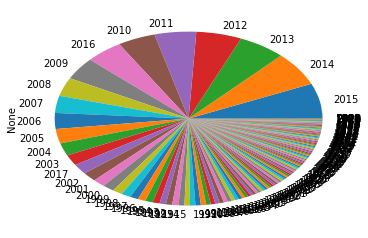

In [22]:
# those are really "1999"
# let's do another eyeballing check
# is the '1999' an unduly large category?
# We should see in pie chart 1999 as a unduly large category
pd.Series([d.year for d in df['year_final_release']],dtype='str').value_counts().plot(kind='pie')


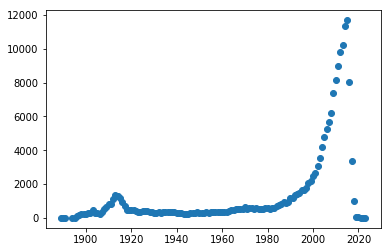

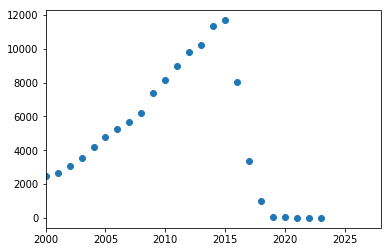

In [23]:
# It is not; how many movies were produced per year seems to be 
# quite randomly distributed
# but there should be a trend: over the past 50 or so years
# more and more movies should have been produced
X = pd.Series([d.year for d in df['year_final_release']]).value_counts()
x = np.array(X.keys())
y = X[x]

plt.scatter(x,y)
plt.show()

# it is an exponential increase as can be expected
# the drop in the end may just be a problem of data collection
# the fresh data is not complete yet; we also see movies
# in the future (beyond 2019); maybe those are announcements of releases
plt.scatter(x,y)
plt.xlim(2000,2028)
plt.show()

In [24]:
# let's already fix imdbVotes too, because we need it later:
problem_entries, x_cast = cast_analysis(df.imdbVotes,cast_func=int)
print(problem_entries[0:10])

[(0, nan), (1, nan), (2, nan), (3, nan), (4, nan), (5, nan), (6, nan), (7, nan), (8, nan), (10, nan)]


In [25]:
# looking at the problems: we have comma-separated
# numbers e.g. 100,000
df.imdbVotes = df.imdbVotes.str.replace(',','')
def get_int(x):
    if pd.isna(x):
        return(np.nan)
    else:
        return(int(x))
    
problem_entries, x_cast = cast_analysis(df.imdbVotes,cast_func=get_int)
print(problem_entries)

[]


In [26]:
# we have successfully cast the imdbVotes variable
df.imdbVotes = x_cast

In [27]:
# and so we will continue
# usually we would have to check all variables and make sure they are in
# a completely machine-readable format
# here let's look firstly at two more variables
#[.....................................Country]

In [28]:
# Let's turn to the next task
# "As a user I´d like to know how many movies the Top10 directors in the data set produced. 
# Prepare a list of the top 10 Directors with the following information"
# Every line is one movie so we need to just look at the Director column
print(df.Director[0:20])


0           Rose Cummings
1             James Byrne
2     Dimitri Buchowetzki
3           Julia Hechler
4         Udara Siriruwan
5        Malini Schueller
6             Philip Shaw
7           Ben F. Wilson
8        Yeong-cheol Choi
9                     NaN
10           David Morris
11          Romeo Candido
12                    NaN
13                    NaN
14           David Gunson
15              Matt Hish
16            Meiert Avis
17           Paul Obazele
18             Fendou Liu
19        Patrick Devaney
Name: Director, dtype: object


In [29]:
# The problem is that one movie may have multiple directors
# split by a ',' or something else
comma_directors = df.Director[[str(v).find(',') != -1 for v in df.Director]]
print(comma_directors[0:10])
print('\n')

semicolon_directors = df.Director[[str(v).find(';') != -1 for v in df.Director]]
print(semicolon_directors[0:10])

21          Terry L. Noss, Richard Rich
34      Nicholas Kohut, Lauren Mountain
44          Darren Powell, Garret Smith
58       Leslie Small, David E. Talbert
69            Benjamin Kim, Jess Koster
89               Ger Duffy, Daire Glynn
95     Clara Kuperberg, Julia Kuperberg
108           Jonathan Ramey, Jeff Ryan
137              Yoni Brook, Musa Syeed
149        Noel Buckner, Rob Whittlesey
Name: Director, dtype: object


47324    Heckle, Dewey &#39;Pigmeat&#39; Markham
Name: Director, dtype: object


In [33]:
# so we have a couple "," cases and also one
# ";" case
print(df.iloc[47324,])

Awards                                                    NaN
Country                                                   USA
DVD                                                       NaN
Director              Heckle, Dewey &#39;Pigmeat&#39; Markham
Language                                              English
Plot                                                      NaN
Poster                                                    NaN
Production                                                NaN
Rated                                                APPROVED
Released                                          27 Aug 1940
Runtime                                                25 min
Title                                    Mr. Smith Goes Ghost
Type                                                    movie
Website                                                   NaN
Year                                                     1940
imdbID                                              tt0234276
imdbRati

In [30]:
# check the directors online and this is a unicode error (?!)
df.Director.replace("Heckle, Dewey &#39;Pigmeat&#39; Markham","Heckle, Dewey 'Pigmeat' Markham",inplace=True)
print(df.Director.iloc[47324])

Heckle, Dewey 'Pigmeat' Markham


In [31]:
# now we have only "," cases left
df['DirectorArray'] = df.Director.str.split(',')


In [32]:
all_dirs = pd.Series(np.hstack(df['DirectorArray']).ravel())

def nan_from_string(x):
    if x == 'nan':
        return (np.nan)
    else:
        return(x)

all_dirs = all_dirs.apply(nan_from_string)

In [33]:
freq_dirs = pd.Series(all_dirs).value_counts()

In [34]:
df_top10 = pd.DataFrame({'Director': freq_dirs.iloc[0:10].index,
                         'NumberOfMovies': freq_dirs.iloc[0:10].values})
df_top10

,Director,NumberOfMovies
0,Jim Powers,156
1,Dave Fleischer,109
2,D.W. Griffith,103
3,Lewin Fitzhamon,95
4,Al Christie,90
5,Georges Méliès,87
6,Gilbert M. 'Broncho Billy' Anderson,85
7,Kevin Dunn,84
8,Quasarman,84
9,Nica Noelle,78


In [78]:
# why there are a bunch of directors here that one does not know
# remains to be google'd (e.g.: Nica Noelle)
# Or try looking at the movies by Jim Powers:
# df.loc[df.Director == 'Jim Powers']
# but we leave this for now...

In [35]:
# Free Data Mining: what else do we want to find out?
#'Do the actors, writer, director have an impact on the imdb scoring?'
# Let's start simple and try to check if director has an impact on rating
# get all Directors and imdbRatings and drop NA's
dfdr = df[['Director','imdbRating','imdbVotes']].dropna(axis=0)
print(dfdr.iloc[1:20,])

                       Director  imdbRating  imdbVotes
16                  Meiert Avis         6.3       11.0
18                   Fendou Liu         5.5       43.0
21  Terry L. Noss, Richard Rich         5.0      813.0
24                  Joseph Kane         7.6       16.0
29               Ernst L. Frank         6.8       10.0
30                    Tom Stone         7.2        5.0
33               Lowell Sherman         7.4       25.0
35                 Jane Campion         6.9       78.0
39                Roland Lethem         7.1       14.0
43                  James Ivory         5.4      777.0
45                  Wallace Fox         5.9        7.0
48                Mário Barroso         5.8      214.0
49                   Russ Meyer         5.1      460.0
51                William Berke         4.8       41.0
52       Denys de La Patellière         6.8      130.0
53                 Maury Dexter         3.7      122.0
54                  Wilson Tong         5.3       21.0
56        

In [36]:
# This question needs to be precisised a bit more here since
# we have a lot of directors, and we cannot simply dummy-code them
# A big studio wants to know how 
# well the mean imdbrating of directors predicts the movie-rating,
# director will be operationalized by their mean
# rating; and hence we would like to know, if on average
# the mean rating of a director is a good predictor of their 
# performance; if all directors had all their movie ratings
# equal their mean rating, then their mean rating
# gives perfect information on movie ratings; however,
# if there is a lot 
# of variance per director across his/her movies in ratings
# then this speaks to low predictiveness of the director's 
# mean rating
# additional predictors can be number of votes, year, ...
# interaction-terms: 
# Dependent variable: rating score of movie
# Independent variable: director's mean movie score, number of votes, 
# interaction
# mean movie score_number_of_votes

# Attention: the data_set is large: we need to work with sub samples
# Attention: we need to exclude all directors that have less than 2 
# rated movies

In [40]:
# get the mean director's rating
# TODO: implement subsampling
def director_rating(rdf):
    return(np.multiply(rdf.imdbRating,rdf.imdbVotes)/np.sum(rdf.imdbVotes))

directors = dfdr.Director.unique()

dirs_ratings = []
len_dirs = len(directors)
for i,d in enumerate(directors):
    rdf = dfdr.loc[df.Director == d,]
    dirs_ratings.append(director_rating(rdf))
    #print(i,end="\r")
    print(i/len_dirs, end="\r")
    
print(dirs_rating)
    
# TODO: create predict function for movie rating 

KeyboardInterrupt: 

In [41]:
rdf

,Director,imdbRating,imdbVotes
362,Sally Mitlas,8.0,16.0
